# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [2]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import time

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [3]:
# Normalize images

'''data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])'''

data_aug = transforms.Compose([
    transforms.ToPILImage(),    
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]

        '''self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)'''

        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1).float()

        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        '''return image, num_pieces.float()'''
        return image, num_pieces.view(-1,1)

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [5]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 32
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([32, 224, 224, 3])
torch.Size([32, 1, 1])
tensor(1)


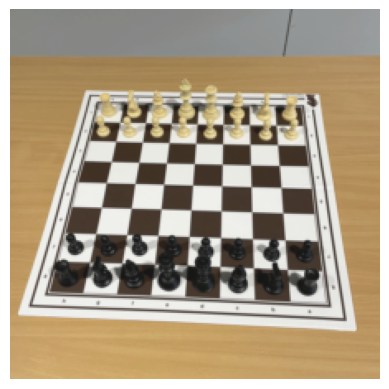

In [6]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# **Now trying new approach with a different model**



## Defining the model

We will use a pre-trained ResNet50 network.

In [7]:
from torchvision.models import efficientnet_b0
import torchvision

# First we started with EfficientNet-B0
# Using ScaledSigmoid activation function for the final layer so the CNN knows the output is a number between 0 and 32 (number of pieces on the board)

class ScaledSigmoid(nn.Module):
    def __init__(self, scale=32.0):
        super(ScaledSigmoid, self).__init__()
        self.scale = scale

    def forward(self, x):
        return torch.sigmoid(x) * self.scale

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# # Load pretrained EfficientNet-B0
model = efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    ScaledSigmoid(scale=32.0)  # Using ScaledSigmoid to output a number between 0 and 32
)

# Move model to device
model.to(device)

# Define loss function 
loss_fn = nn.HuberLoss() # nn.MSELoss() or nn.L1Loss() can also be used

Using cuda device


## Train the model

Define function to perform one iteration

In [8]:
def accuracy_tolerance(outputs, labels, tol=1):
    preds = torch.round(outputs)
    correct = (torch.abs(preds - labels) <= tol).float()
    return correct.mean().item()

def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    model.train() if is_train else model.eval()
    
    images = images.to(device, non_blocking=True)
    labels = labels.to(device).float().view(-1, 1)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)  # More memory efficient
            loss.backward()
            optimizer.step()

    return loss.item(), outputs.detach()

Define function to train a model

In [9]:
def evaluate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.
    running_mae = 0.
    running_acc = 0.
    running_mse = 0.
    total_samples = 0

    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)

            loss = criterion(outputs, labels)
            mae = F.l1_loss(outputs, labels)
            mse = F.mse_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            running_mse += mse.item() * batch_size
            total_samples += batch_size

            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    all_labels = torch.cat(all_labels).squeeze()
    all_outputs = torch.cat(all_outputs).squeeze()

    ss_res = torch.sum((all_labels - all_outputs) ** 2)
    ss_tot = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    r2 = 1 - ss_res / ss_tot

    avg_loss = running_loss / total_samples
    avg_mae = running_mae / total_samples
    avg_acc = running_acc / total_samples
    avg_mse = running_mse / total_samples
    avg_rmse = avg_mse ** 0.5

    return avg_loss, avg_mae, avg_acc, avg_mse, avg_rmse, r2.item()


In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, scheduler=None, num_epochs=10):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    # Train Metrics: loss, mae, acc±1 (accuracy within tolerance of 1), only 3 metrics for low cost training
    train_history = {'loss': [], 'mae': [], 'acc±1': []}
    # Validation Metrics: loss, mae, acc±1, mse, rmse, r2, all 6 metrics for comprehensive evaluation
    val_history = {'loss': [], 'mae': [], 'acc±1': [], 'mse': [], 'rmse': [], 'r2': []}

    total_train_time = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        # ===== TRAINING =====
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        running_acc = 0.0
        total_samples = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)

            labels = labels.to(device).float().view(-1, 1)
            mae = F.l1_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            total_samples += batch_size

            train_bar.set_postfix(loss=running_loss/total_samples, MAE=running_mae/total_samples, acc=f"{(running_acc/total_samples)*100:.2f}%")

        train_loss = running_loss / total_samples
        train_mae = running_mae / total_samples
        train_acc = running_acc / total_samples

        train_history['loss'].append(train_loss)
        train_history['mae'].append(train_mae)
        train_history['acc±1'].append(train_acc)

        print(f"✔️ Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.4f} | Train Acc±1: {train_acc*100:.2f}%")

        epoch_time = time.time() - epoch_start_time
        total_train_time += epoch_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds.")

        # ===== VALIDATION =====
        if val_loader:
            val_loss, val_mae, val_acc, val_mse, val_rmse, val_r2 = evaluate(val_loader, model, criterion, device)

            val_history['loss'].append(val_loss)
            val_history['mae'].append(val_mae)
            val_history['acc±1'].append(val_acc)
            val_history['mse'].append(val_mse)
            val_history['rmse'].append(val_rmse)
            val_history['r2'].append(val_r2)

            print(f"🔍 Validation Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | Acc±1: {val_acc*100:.2f}% | MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | R2: {val_r2:.4f}")

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with val loss: {best_val_loss:.4f}")

            # Update the learning rate if using a scheduler
            if scheduler:
                scheduler.step(val_loss)

    print(f"\nTotal training time: {total_train_time:.2f} seconds.")
    return train_history, val_history, total_train_time


Define loss, optimizer and train the model

In [11]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(2, 3, 2)
    plt.plot(train_history['mae'], label='Train MAE')
    plt.plot(val_history['mae'], label='Val MAE')
    plt.title('MAE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    # Accuracy ±1
    plt.subplot(2, 3, 3)
    plt.plot(train_history['acc±1'], label='Train Acc ±1')
    plt.plot(val_history['acc±1'], label='Val Acc ±1')
    plt.title('Accuracy ±1 over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy ±1')
    plt.legend()

    # MSE (Validation only)
    plt.subplot(2, 3, 4)
    plt.plot(val_history['mse'], label='Val MSE', color='orange')
    plt.title('Validation MSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # RMSE (Validation only)
    plt.subplot(2, 3, 5)
    plt.plot(val_history['rmse'], label='Val RMSE', color='green')
    plt.title('Validation RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    # R² (Validation only)
    plt.subplot(2, 3, 6)
    plt.plot(val_history['r2'], label='Val R²', color='red')
    plt.title('Validation R² over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.tight_layout()
    plt.show()


## **Try another approach for freezing/unfreezing layers**


In [12]:
# Get total number of blocks in model.features
total_blocks = len(list(model.features))

def unfreeze_blocks(model, n):
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
    
    # Always unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Unfreeze last n blocks in features
    if n > 0:
        if hasattr(model, 'features') and isinstance(model.features, nn.Sequential):
            features_blocks = list(model.features)
            for block in features_blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True
        else:
            raise ValueError("Model.features is not an nn.Sequential or not present.")

def is_stuck(val_losses, patience=3, min_delta=1e-3):
    if len(val_losses) < patience + 1:
        return False
    # Check if the average improvement in last 'patience' steps is less than min_delta
    recent = val_losses[-(patience+1):]
    improvements = [recent[i] - recent[i+1] for i in range(patience)]
    avg_improvement = sum(improvements) / patience
    return avg_improvement < min_delta

# Training parameters
num_epochs_per_step = 3
max_unfreeze_blocks = total_blocks
blocks_to_unfreeze_each_step = 1  # Unfreeze one block at a time
current_unfreeze_blocks = 1  # Start with 1 block unfrozen

max_total_epochs = 75
epochs_trained = 0

# Initialize with first block unfrozen
unfreeze_blocks(model, current_unfreeze_blocks)

# Setup optimizer with all trainable parameters
params_to_optimize = [
    {'params': model.classifier.parameters(), 'lr': 1e-3},
    {'params': [p for block in list(model.features)[-current_unfreeze_blocks:] 
               for p in block.parameters()], 'lr': 1e-4}
]
optimizer = optim.AdamW(params_to_optimize, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training history
train_history_all = {'loss': [], 'mae': [], 'acc±1': []}
val_history_all = {'loss': [], 'mae': [], 'acc±1': [], 'mse': [], 'rmse': [], 'r2': []}

while current_unfreeze_blocks <= max_unfreeze_blocks and epochs_trained < max_total_epochs:
    print(f"\n=== Training with last {current_unfreeze_blocks} blocks unfrozen ===")
    
    # Train model
    train_hist, val_hist, epoch_time = train_model(
        model, train_dataloader, valid_dataloader,
        optimizer, loss_fn, device,
        scheduler=scheduler,
        num_epochs=num_epochs_per_step
    )
    
    # Update histories
    for key in train_history_all:
        train_history_all[key].extend(train_hist.get(key, []))
    for key in val_history_all:
        val_history_all[key].extend(val_hist.get(key, []))
    
    epochs_trained += num_epochs_per_step
    
    # Check if we should unfreeze more blocks
    if len(val_history_all['loss']) >= 4 and is_stuck(val_history_all['loss']):
        new_unfreeze = min(current_unfreeze_blocks + blocks_to_unfreeze_each_step, max_unfreeze_blocks)
        
        if new_unfreeze > current_unfreeze_blocks:
            print(f"Unfreezing more blocks: from {current_unfreeze_blocks} to {new_unfreeze}")
            current_unfreeze_blocks = new_unfreeze
            unfreeze_blocks(model, current_unfreeze_blocks)
            
            # Create new optimizer with updated parameters
            params_to_optimize = [
                {'params': model.classifier.parameters(), 'lr': 1e-3},
                {'params': [p for block in list(model.features)[-current_unfreeze_blocks:] 
                          for p in block.parameters()], 'lr': 1e-4}
            ]
            
            # Save optimizer state
            old_state = optimizer.state_dict()
            
            # Create new optimizer
            optimizer = optim.AdamW(params_to_optimize, weight_decay=1e-4)
            
            # Transfer state for existing parameters
            new_state = optimizer.state_dict()
            for param in old_state['state']:
                if param in new_state['state']:
                    new_state['state'][param] = old_state['state'][param]
            optimizer.load_state_dict(new_state)
            
            # Reset scheduler with new optimizer
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=2
            )
        else:
            print("All blocks already unfrozen. Continuing training.")
    
    # Early stopping if validation loss is NaN or very high
    if len(val_history_all['loss']) > 0 and (np.isnan(val_history_all['loss'][-1]) or val_history_all['loss'][-1] > 1e3):
        print("Validation loss exploded. Stopping training.")
        break

print(f"\nTraining finished. Total epochs: {epochs_trained}")


=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 4.4829 | Train MAE: 4.9610 | Train Acc±1: 17.78%
Epoch 1 took 200.44 seconds.
🔍 Validation Loss: 2.7403 | MAE: 3.2126 | Acc±1: 28.48% | MSE: 16.6321 | RMSE: 4.0782 | R2: 0.7819
💾 Best model saved with val loss: 2.7403

Epoch 2/3


✔️ Train Loss: 3.2942 | Train MAE: 3.7660 | Train Acc±1: 27.01%
Epoch 2 took 190.09 seconds.
🔍 Validation Loss: 3.0465 | MAE: 3.5211 | Acc±1: 25.15% | MSE: 20.1294 | RMSE: 4.4866 | R2: 0.7361

Epoch 3/3


✔️ Train Loss: 3.1232 | Train MAE: 3.5899 | Train Acc±1: 29.44%
Epoch 3 took 188.87 seconds.
🔍 Validation Loss: 2.4718 | MAE: 2.9372 | Acc±1: 30.00% | MSE: 13.8847 | RMSE: 3.7262 | R2: 0.8180
💾 Best model saved with val loss: 2.4718

Total training time: 579.40 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.9416 | Train MAE: 3.4054 | Train Acc±1: 30.21%
Epoch 1 took 191.35 seconds.
🔍 Validation Loss: 2.6675 | MAE: 3.1386 | Acc±1: 28.79% | MSE: 15.5352 | RMSE: 3.9415 | R2: 0.7963
💾 Best model saved with val loss: 2.6675

Epoch 2/3


✔️ Train Loss: 2.8209 | Train MAE: 3.2807 | Train Acc±1: 33.54%
Epoch 2 took 188.77 seconds.
🔍 Validation Loss: 2.6090 | MAE: 3.0721 | Acc±1: 29.09% | MSE: 15.3525 | RMSE: 3.9182 | R2: 0.7987
💾 Best model saved with val loss: 2.6090

Epoch 3/3


✔️ Train Loss: 2.7738 | Train MAE: 3.2300 | Train Acc±1: 32.71%
Epoch 3 took 188.65 seconds.
🔍 Validation Loss: 2.1242 | MAE: 2.5771 | Acc±1: 37.88% | MSE: 11.1762 | RMSE: 3.3431 | R2: 0.8535
💾 Best model saved with val loss: 2.1242

Total training time: 568.77 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.6129 | Train MAE: 3.0680 | Train Acc±1: 35.21%
Epoch 1 took 188.06 seconds.
🔍 Validation Loss: 2.2185 | MAE: 2.6773 | Acc±1: 37.88% | MSE: 11.9787 | RMSE: 3.4610 | R2: 0.8430
💾 Best model saved with val loss: 2.2185

Epoch 2/3


✔️ Train Loss: 2.4652 | Train MAE: 2.9205 | Train Acc±1: 37.22%
Epoch 2 took 189.08 seconds.
🔍 Validation Loss: 2.4919 | MAE: 2.9526 | Acc±1: 33.33% | MSE: 14.0271 | RMSE: 3.7453 | R2: 0.8161

Epoch 3/3


✔️ Train Loss: 2.4254 | Train MAE: 2.8759 | Train Acc±1: 37.64%
Epoch 3 took 188.39 seconds.
🔍 Validation Loss: 2.0799 | MAE: 2.5335 | Acc±1: 41.21% | MSE: 10.8903 | RMSE: 3.3000 | R2: 0.8572
💾 Best model saved with val loss: 2.0799

Total training time: 565.54 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.4506 | Train MAE: 2.9007 | Train Acc±1: 36.46%
Epoch 1 took 188.60 seconds.
🔍 Validation Loss: 2.2197 | MAE: 2.6725 | Acc±1: 38.79% | MSE: 12.6868 | RMSE: 3.5619 | R2: 0.8337
💾 Best model saved with val loss: 2.2197

Epoch 2/3


✔️ Train Loss: 2.3504 | Train MAE: 2.8010 | Train Acc±1: 38.75%
Epoch 2 took 188.24 seconds.
🔍 Validation Loss: 2.2734 | MAE: 2.7317 | Acc±1: 35.76% | MSE: 12.0996 | RMSE: 3.4784 | R2: 0.8414

Epoch 3/3


✔️ Train Loss: 2.4508 | Train MAE: 2.9002 | Train Acc±1: 36.32%
Epoch 3 took 188.00 seconds.
🔍 Validation Loss: 2.0487 | MAE: 2.4972 | Acc±1: 44.24% | MSE: 11.3496 | RMSE: 3.3689 | R2: 0.8512
💾 Best model saved with val loss: 2.0487

Total training time: 564.84 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.3507 | Train MAE: 2.7934 | Train Acc±1: 39.24%
Epoch 1 took 189.05 seconds.
🔍 Validation Loss: 2.2857 | MAE: 2.7324 | Acc±1: 40.00% | MSE: 13.1104 | RMSE: 3.6208 | R2: 0.8281
💾 Best model saved with val loss: 2.2857

Epoch 2/3


✔️ Train Loss: 2.1840 | Train MAE: 2.6279 | Train Acc±1: 40.76%
Epoch 2 took 188.72 seconds.
🔍 Validation Loss: 2.1380 | MAE: 2.5911 | Acc±1: 37.58% | MSE: 11.3420 | RMSE: 3.3678 | R2: 0.8513
💾 Best model saved with val loss: 2.1380

Epoch 3/3


✔️ Train Loss: 2.3129 | Train MAE: 2.7593 | Train Acc±1: 38.40%
Epoch 3 took 188.04 seconds.
🔍 Validation Loss: 1.9355 | MAE: 2.3765 | Acc±1: 42.73% | MSE: 9.7477 | RMSE: 3.1221 | R2: 0.8722
💾 Best model saved with val loss: 1.9355

Total training time: 565.81 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.0816 | Train MAE: 2.5277 | Train Acc±1: 40.42%
Epoch 1 took 188.85 seconds.
🔍 Validation Loss: 2.0357 | MAE: 2.4843 | Acc±1: 41.82% | MSE: 10.7041 | RMSE: 3.2717 | R2: 0.8597
💾 Best model saved with val loss: 2.0357

Epoch 2/3


✔️ Train Loss: 2.1606 | Train MAE: 2.6048 | Train Acc±1: 40.35%
Epoch 2 took 188.88 seconds.
🔍 Validation Loss: 1.9143 | MAE: 2.3558 | Acc±1: 41.82% | MSE: 9.1941 | RMSE: 3.0322 | R2: 0.8795
💾 Best model saved with val loss: 1.9143

Epoch 3/3


✔️ Train Loss: 2.1346 | Train MAE: 2.5814 | Train Acc±1: 39.31%
Epoch 3 took 188.73 seconds.
🔍 Validation Loss: 2.0641 | MAE: 2.5166 | Acc±1: 40.91% | MSE: 10.3175 | RMSE: 3.2121 | R2: 0.8647

Total training time: 566.47 seconds.
Unfreezing more blocks: from 1 to 2

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.2001 | Train MAE: 2.6484 | Train Acc±1: 40.35%
Epoch 1 took 188.36 seconds.
🔍 Validation Loss: 2.1611 | MAE: 2.6089 | Acc±1: 36.97% | MSE: 11.2124 | RMSE: 3.3485 | R2: 0.8530
💾 Best model saved with val loss: 2.1611

Epoch 2/3


✔️ Train Loss: 2.0928 | Train MAE: 2.5352 | Train Acc±1: 40.90%
Epoch 2 took 188.16 seconds.
🔍 Validation Loss: 1.8441 | MAE: 2.2779 | Acc±1: 43.94% | MSE: 9.3709 | RMSE: 3.0612 | R2: 0.8771
💾 Best model saved with val loss: 1.8441

Epoch 3/3


✔️ Train Loss: 1.9241 | Train MAE: 2.3612 | Train Acc±1: 43.54%
Epoch 3 took 188.65 seconds.
🔍 Validation Loss: 1.8622 | MAE: 2.2953 | Acc±1: 44.85% | MSE: 9.3814 | RMSE: 3.0629 | R2: 0.8770

Total training time: 565.18 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.7664 | Train MAE: 2.2003 | Train Acc±1: 46.74%
Epoch 1 took 188.40 seconds.
🔍 Validation Loss: 1.9353 | MAE: 2.3804 | Acc±1: 40.91% | MSE: 9.3492 | RMSE: 3.0576 | R2: 0.8774
💾 Best model saved with val loss: 1.9353

Epoch 2/3


✔️ Train Loss: 1.8006 | Train MAE: 2.2345 | Train Acc±1: 45.35%
Epoch 2 took 187.88 seconds.
🔍 Validation Loss: 1.7824 | MAE: 2.2143 | Acc±1: 46.06% | MSE: 8.4673 | RMSE: 2.9099 | R2: 0.8890
💾 Best model saved with val loss: 1.7824

Epoch 3/3


✔️ Train Loss: 1.7304 | Train MAE: 2.1661 | Train Acc±1: 45.76%
Epoch 3 took 189.16 seconds.
🔍 Validation Loss: 1.9007 | MAE: 2.3442 | Acc±1: 42.12% | MSE: 9.1111 | RMSE: 3.0185 | R2: 0.8805

Total training time: 565.43 seconds.
Unfreezing more blocks: from 2 to 3

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.6599 | Train MAE: 2.0914 | Train Acc±1: 48.68%
Epoch 1 took 189.16 seconds.
🔍 Validation Loss: 1.6517 | MAE: 2.0885 | Acc±1: 46.67% | MSE: 7.7616 | RMSE: 2.7860 | R2: 0.8982
💾 Best model saved with val loss: 1.6517

Epoch 2/3


✔️ Train Loss: 1.6381 | Train MAE: 2.0747 | Train Acc±1: 47.43%
Epoch 2 took 188.54 seconds.
🔍 Validation Loss: 1.6716 | MAE: 2.1162 | Acc±1: 41.82% | MSE: 7.0665 | RMSE: 2.6583 | R2: 0.9074

Epoch 3/3


✔️ Train Loss: 1.4740 | Train MAE: 1.9040 | Train Acc±1: 48.54%
Epoch 3 took 189.32 seconds.
🔍 Validation Loss: 1.8224 | MAE: 2.2738 | Acc±1: 36.36% | MSE: 7.7998 | RMSE: 2.7928 | R2: 0.8977

Total training time: 567.02 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.4177 | Train MAE: 1.8448 | Train Acc±1: 53.68%
Epoch 1 took 188.82 seconds.
🔍 Validation Loss: 1.4733 | MAE: 1.9019 | Acc±1: 45.45% | MSE: 5.7811 | RMSE: 2.4044 | R2: 0.9242
💾 Best model saved with val loss: 1.4733

Epoch 2/3


✔️ Train Loss: 1.3431 | Train MAE: 1.7671 | Train Acc±1: 52.15%
Epoch 2 took 189.52 seconds.
🔍 Validation Loss: 1.5865 | MAE: 2.0130 | Acc±1: 44.55% | MSE: 6.6795 | RMSE: 2.5845 | R2: 0.9124

Epoch 3/3


✔️ Train Loss: 1.6040 | Train MAE: 2.0313 | Train Acc±1: 49.38%
Epoch 3 took 189.33 seconds.
🔍 Validation Loss: 1.3433 | MAE: 1.7743 | Acc±1: 54.55% | MSE: 5.3502 | RMSE: 2.3131 | R2: 0.9299
💾 Best model saved with val loss: 1.3433

Total training time: 567.68 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.3324 | Train MAE: 1.7566 | Train Acc±1: 53.96%
Epoch 1 took 189.13 seconds.
🔍 Validation Loss: 1.3429 | MAE: 1.7735 | Acc±1: 51.21% | MSE: 5.2335 | RMSE: 2.2877 | R2: 0.9314
💾 Best model saved with val loss: 1.3429

Epoch 2/3


✔️ Train Loss: 1.2016 | Train MAE: 1.6138 | Train Acc±1: 57.71%
Epoch 2 took 189.00 seconds.
🔍 Validation Loss: 1.3314 | MAE: 1.7680 | Acc±1: 50.91% | MSE: 5.0431 | RMSE: 2.2457 | R2: 0.9339
💾 Best model saved with val loss: 1.3314

Epoch 3/3


✔️ Train Loss: 1.1540 | Train MAE: 1.5747 | Train Acc±1: 56.88%
Epoch 3 took 189.72 seconds.
🔍 Validation Loss: 1.3060 | MAE: 1.7302 | Acc±1: 50.30% | MSE: 5.0736 | RMSE: 2.2525 | R2: 0.9335
💾 Best model saved with val loss: 1.3060

Total training time: 567.86 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.1934 | Train MAE: 1.6103 | Train Acc±1: 56.04%
Epoch 1 took 188.68 seconds.
🔍 Validation Loss: 1.3975 | MAE: 1.8312 | Acc±1: 47.27% | MSE: 5.3088 | RMSE: 2.3041 | R2: 0.9304
💾 Best model saved with val loss: 1.3975

Epoch 2/3


✔️ Train Loss: 1.0900 | Train MAE: 1.4971 | Train Acc±1: 60.07%
Epoch 2 took 188.25 seconds.
🔍 Validation Loss: 1.3445 | MAE: 1.7729 | Acc±1: 50.61% | MSE: 5.1805 | RMSE: 2.2761 | R2: 0.9321
💾 Best model saved with val loss: 1.3445

Epoch 3/3


✔️ Train Loss: 1.1044 | Train MAE: 1.5244 | Train Acc±1: 58.89%
Epoch 3 took 188.46 seconds.
🔍 Validation Loss: 1.2965 | MAE: 1.7210 | Acc±1: 48.18% | MSE: 4.6865 | RMSE: 2.1648 | R2: 0.9386
💾 Best model saved with val loss: 1.2965

Total training time: 565.39 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.0923 | Train MAE: 1.5087 | Train Acc±1: 60.62%
Epoch 1 took 189.73 seconds.
🔍 Validation Loss: 1.3503 | MAE: 1.7762 | Acc±1: 47.58% | MSE: 5.1851 | RMSE: 2.2771 | R2: 0.9320
💾 Best model saved with val loss: 1.3503

Epoch 2/3


✔️ Train Loss: 1.0028 | Train MAE: 1.4170 | Train Acc±1: 62.85%
Epoch 2 took 188.67 seconds.
🔍 Validation Loss: 1.2855 | MAE: 1.7161 | Acc±1: 49.39% | MSE: 4.7309 | RMSE: 2.1751 | R2: 0.9380
💾 Best model saved with val loss: 1.2855

Epoch 3/3


✔️ Train Loss: 0.9827 | Train MAE: 1.3895 | Train Acc±1: 64.03%
Epoch 3 took 188.68 seconds.
🔍 Validation Loss: 1.2764 | MAE: 1.7039 | Acc±1: 51.82% | MSE: 4.6852 | RMSE: 2.1645 | R2: 0.9386
💾 Best model saved with val loss: 1.2764

Total training time: 567.07 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.0002 | Train MAE: 1.4127 | Train Acc±1: 62.92%
Epoch 1 took 188.43 seconds.
🔍 Validation Loss: 1.2866 | MAE: 1.7175 | Acc±1: 50.91% | MSE: 4.6790 | RMSE: 2.1631 | R2: 0.9387
💾 Best model saved with val loss: 1.2866

Epoch 2/3


✔️ Train Loss: 0.9929 | Train MAE: 1.3993 | Train Acc±1: 61.60%
Epoch 2 took 189.96 seconds.
🔍 Validation Loss: 1.1634 | MAE: 1.5849 | Acc±1: 57.88% | MSE: 4.3110 | RMSE: 2.0763 | R2: 0.9435
💾 Best model saved with val loss: 1.1634

Epoch 3/3


✔️ Train Loss: 1.0383 | Train MAE: 1.4472 | Train Acc±1: 61.67%
Epoch 3 took 188.73 seconds.
🔍 Validation Loss: 1.1714 | MAE: 1.5960 | Acc±1: 54.24% | MSE: 4.2220 | RMSE: 2.0547 | R2: 0.9446

Total training time: 567.12 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.9603 | Train MAE: 1.3648 | Train Acc±1: 64.51%
Epoch 1 took 189.01 seconds.
🔍 Validation Loss: 1.2543 | MAE: 1.6846 | Acc±1: 52.73% | MSE: 4.6028 | RMSE: 2.1454 | R2: 0.9397
💾 Best model saved with val loss: 1.2543

Epoch 2/3


✔️ Train Loss: 0.9804 | Train MAE: 1.3874 | Train Acc±1: 62.50%
Epoch 2 took 189.08 seconds.
🔍 Validation Loss: 1.3026 | MAE: 1.7302 | Acc±1: 52.42% | MSE: 4.8607 | RMSE: 2.2047 | R2: 0.9363

Epoch 3/3


✔️ Train Loss: 0.7848 | Train MAE: 1.1812 | Train Acc±1: 69.79%
Epoch 3 took 188.22 seconds.
🔍 Validation Loss: 1.1459 | MAE: 1.5664 | Acc±1: 53.94% | MSE: 4.0451 | RMSE: 2.0112 | R2: 0.9470
💾 Best model saved with val loss: 1.1459

Total training time: 566.32 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.8544 | Train MAE: 1.2561 | Train Acc±1: 66.25%
Epoch 1 took 188.33 seconds.
🔍 Validation Loss: 1.2239 | MAE: 1.6510 | Acc±1: 53.03% | MSE: 4.4621 | RMSE: 2.1124 | R2: 0.9415
💾 Best model saved with val loss: 1.2239

Epoch 2/3


✔️ Train Loss: 0.8145 | Train MAE: 1.2055 | Train Acc±1: 69.79%
Epoch 2 took 189.28 seconds.
🔍 Validation Loss: 1.2025 | MAE: 1.6296 | Acc±1: 54.85% | MSE: 4.4039 | RMSE: 2.0986 | R2: 0.9423
💾 Best model saved with val loss: 1.2025

Epoch 3/3


✔️ Train Loss: 0.8768 | Train MAE: 1.2864 | Train Acc±1: 66.67%
Epoch 3 took 188.89 seconds.
🔍 Validation Loss: 1.1798 | MAE: 1.6018 | Acc±1: 54.55% | MSE: 4.3560 | RMSE: 2.0871 | R2: 0.9429
💾 Best model saved with val loss: 1.1798

Total training time: 566.50 seconds.
Unfreezing more blocks: from 3 to 4

=== Training with last 4 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.9141 | Train MAE: 1.3139 | Train Acc±1: 66.25%
Epoch 1 took 189.80 seconds.
🔍 Validation Loss: 1.3556 | MAE: 1.7782 | Acc±1: 48.18% | MSE: 5.2519 | RMSE: 2.2917 | R2: 0.9311
💾 Best model saved with val loss: 1.3556

Epoch 2/3


✔️ Train Loss: 0.8594 | Train MAE: 1.2557 | Train Acc±1: 67.43%
Epoch 2 took 188.48 seconds.
🔍 Validation Loss: 1.5304 | MAE: 1.9581 | Acc±1: 44.24% | MSE: 6.0903 | RMSE: 2.4679 | R2: 0.9202

Epoch 3/3


✔️ Train Loss: 0.9080 | Train MAE: 1.3106 | Train Acc±1: 66.04%
Epoch 3 took 188.99 seconds.
🔍 Validation Loss: 1.0065 | MAE: 1.4271 | Acc±1: 63.94% | MSE: 3.4814 | RMSE: 1.8659 | R2: 0.9544
💾 Best model saved with val loss: 1.0065

Total training time: 567.27 seconds.

=== Training with last 4 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.8533 | Train MAE: 1.2526 | Train Acc±1: 67.01%
Epoch 1 took 188.91 seconds.
🔍 Validation Loss: 1.2988 | MAE: 1.7367 | Acc±1: 49.70% | MSE: 4.8253 | RMSE: 2.1966 | R2: 0.9367
💾 Best model saved with val loss: 1.2988

Epoch 2/3


✔️ Train Loss: 0.8084 | Train MAE: 1.2081 | Train Acc±1: 69.31%
Epoch 2 took 189.47 seconds.
🔍 Validation Loss: 1.1508 | MAE: 1.5776 | Acc±1: 58.48% | MSE: 4.2052 | RMSE: 2.0506 | R2: 0.9449
💾 Best model saved with val loss: 1.1508

Epoch 3/3


✔️ Train Loss: 0.7888 | Train MAE: 1.1763 | Train Acc±1: 70.07%
Epoch 3 took 189.62 seconds.
🔍 Validation Loss: 1.1357 | MAE: 1.5615 | Acc±1: 55.15% | MSE: 3.9721 | RMSE: 1.9930 | R2: 0.9479
💾 Best model saved with val loss: 1.1357

Total training time: 568.00 seconds.
Unfreezing more blocks: from 4 to 5

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.7938 | Train MAE: 1.1838 | Train Acc±1: 68.82%
Epoch 1 took 189.26 seconds.
🔍 Validation Loss: 1.2823 | MAE: 1.7090 | Acc±1: 51.21% | MSE: 4.7171 | RMSE: 2.1719 | R2: 0.9382
💾 Best model saved with val loss: 1.2823

Epoch 2/3


✔️ Train Loss: 0.7443 | Train MAE: 1.1357 | Train Acc±1: 72.01%
Epoch 2 took 188.43 seconds.
🔍 Validation Loss: 1.2600 | MAE: 1.6909 | Acc±1: 52.73% | MSE: 4.6498 | RMSE: 2.1563 | R2: 0.9390
💾 Best model saved with val loss: 1.2600

Epoch 3/3


✔️ Train Loss: 0.7951 | Train MAE: 1.1831 | Train Acc±1: 69.86%
Epoch 3 took 189.51 seconds.
🔍 Validation Loss: 1.0628 | MAE: 1.4838 | Acc±1: 59.70% | MSE: 3.7273 | RMSE: 1.9306 | R2: 0.9511
💾 Best model saved with val loss: 1.0628

Total training time: 567.20 seconds.

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.7704 | Train MAE: 1.1611 | Train Acc±1: 70.56%
Epoch 1 took 189.53 seconds.
🔍 Validation Loss: 1.0469 | MAE: 1.4643 | Acc±1: 57.88% | MSE: 3.6390 | RMSE: 1.9076 | R2: 0.9523
💾 Best model saved with val loss: 1.0469

Epoch 2/3


✔️ Train Loss: 0.7021 | Train MAE: 1.0944 | Train Acc±1: 72.92%
Epoch 2 took 189.02 seconds.
🔍 Validation Loss: 1.0492 | MAE: 1.4687 | Acc±1: 59.09% | MSE: 3.4836 | RMSE: 1.8664 | R2: 0.9543

Epoch 3/3


✔️ Train Loss: 0.6563 | Train MAE: 1.0425 | Train Acc±1: 75.07%
Epoch 3 took 189.56 seconds.
🔍 Validation Loss: 1.1185 | MAE: 1.5381 | Acc±1: 56.06% | MSE: 3.9189 | RMSE: 1.9796 | R2: 0.9486

Total training time: 568.11 seconds.
Unfreezing more blocks: from 5 to 6

=== Training with last 6 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.7483 | Train MAE: 1.1349 | Train Acc±1: 70.69%
Epoch 1 took 189.51 seconds.
🔍 Validation Loss: 1.1858 | MAE: 1.6100 | Acc±1: 52.42% | MSE: 4.1932 | RMSE: 2.0477 | R2: 0.9450
💾 Best model saved with val loss: 1.1858

Epoch 2/3


✔️ Train Loss: 0.7090 | Train MAE: 1.1020 | Train Acc±1: 72.85%
Epoch 2 took 188.72 seconds.
🔍 Validation Loss: 1.2195 | MAE: 1.6459 | Acc±1: 53.33% | MSE: 4.3571 | RMSE: 2.0874 | R2: 0.9429

Epoch 3/3


✔️ Train Loss: 0.6540 | Train MAE: 1.0375 | Train Acc±1: 75.56%
Epoch 3 took 189.46 seconds.
🔍 Validation Loss: 1.0443 | MAE: 1.4546 | Acc±1: 59.09% | MSE: 3.5870 | RMSE: 1.8939 | R2: 0.9530
💾 Best model saved with val loss: 1.0443

Total training time: 567.69 seconds.

=== Training with last 6 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.7200 | Train MAE: 1.1039 | Train Acc±1: 71.32%
Epoch 1 took 189.36 seconds.
🔍 Validation Loss: 1.2854 | MAE: 1.7087 | Acc±1: 50.91% | MSE: 4.7924 | RMSE: 2.1891 | R2: 0.9372
💾 Best model saved with val loss: 1.2854

Epoch 2/3


✔️ Train Loss: 0.5724 | Train MAE: 0.9492 | Train Acc±1: 79.17%
Epoch 2 took 189.31 seconds.
🔍 Validation Loss: 1.2565 | MAE: 1.6891 | Acc±1: 53.33% | MSE: 4.5872 | RMSE: 2.1418 | R2: 0.9399
💾 Best model saved with val loss: 1.2565

Epoch 3/3


✔️ Train Loss: 0.6534 | Train MAE: 1.0324 | Train Acc±1: 75.49%
Epoch 3 took 189.52 seconds.
🔍 Validation Loss: 1.1017 | MAE: 1.5056 | Acc±1: 56.97% | MSE: 3.9081 | RMSE: 1.9769 | R2: 0.9488
💾 Best model saved with val loss: 1.1017

Total training time: 568.19 seconds.
Unfreezing more blocks: from 6 to 7

=== Training with last 7 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.5982 | Train MAE: 0.9703 | Train Acc±1: 76.46%
Epoch 1 took 191.11 seconds.
🔍 Validation Loss: 1.2178 | MAE: 1.6491 | Acc±1: 53.03% | MSE: 4.3013 | RMSE: 2.0740 | R2: 0.9436
💾 Best model saved with val loss: 1.2178

Epoch 2/3


✔️ Train Loss: 0.5494 | Train MAE: 0.9201 | Train Acc±1: 78.89%
Epoch 2 took 190.78 seconds.
🔍 Validation Loss: 1.1224 | MAE: 1.5422 | Acc±1: 54.55% | MSE: 3.8218 | RMSE: 1.9549 | R2: 0.9499
💾 Best model saved with val loss: 1.1224

Epoch 3/3


✔️ Train Loss: 0.6059 | Train MAE: 0.9803 | Train Acc±1: 77.01%
Epoch 3 took 190.54 seconds.
🔍 Validation Loss: 1.0556 | MAE: 1.4712 | Acc±1: 58.48% | MSE: 3.5654 | RMSE: 1.8882 | R2: 0.9533
💾 Best model saved with val loss: 1.0556

Total training time: 572.43 seconds.

=== Training with last 7 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.5924 | Train MAE: 0.9668 | Train Acc±1: 77.08%
Epoch 1 took 191.30 seconds.
🔍 Validation Loss: 1.1393 | MAE: 1.5583 | Acc±1: 55.45% | MSE: 3.9483 | RMSE: 1.9870 | R2: 0.9482
💾 Best model saved with val loss: 1.1393

Epoch 2/3


✔️ Train Loss: 0.5495 | Train MAE: 0.9132 | Train Acc±1: 79.72%
Epoch 2 took 191.46 seconds.
🔍 Validation Loss: 0.9420 | MAE: 1.3434 | Acc±1: 61.21% | MSE: 3.0019 | RMSE: 1.7326 | R2: 0.9606
💾 Best model saved with val loss: 0.9420

Epoch 3/3


✔️ Train Loss: 0.5098 | Train MAE: 0.8688 | Train Acc±1: 83.06%
Epoch 3 took 189.51 seconds.
🔍 Validation Loss: 1.1461 | MAE: 1.5679 | Acc±1: 54.85% | MSE: 3.9192 | RMSE: 1.9797 | R2: 0.9486

Total training time: 572.27 seconds.
Unfreezing more blocks: from 7 to 8

=== Training with last 8 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.5113 | Train MAE: 0.8701 | Train Acc±1: 82.29%
Epoch 1 took 191.30 seconds.
🔍 Validation Loss: 1.0087 | MAE: 1.4193 | Acc±1: 58.48% | MSE: 3.1946 | RMSE: 1.7874 | R2: 0.9581
💾 Best model saved with val loss: 1.0087

Epoch 2/3


✔️ Train Loss: 0.4599 | Train MAE: 0.8141 | Train Acc±1: 84.44%
Epoch 2 took 190.76 seconds.
🔍 Validation Loss: 1.0026 | MAE: 1.4131 | Acc±1: 56.97% | MSE: 3.1433 | RMSE: 1.7729 | R2: 0.9588
💾 Best model saved with val loss: 1.0026

Epoch 3/3


✔️ Train Loss: 0.4482 | Train MAE: 0.8004 | Train Acc±1: 83.68%
Epoch 3 took 191.38 seconds.
🔍 Validation Loss: 0.8934 | MAE: 1.3032 | Acc±1: 62.12% | MSE: 2.6828 | RMSE: 1.6379 | R2: 0.9648
💾 Best model saved with val loss: 0.8934

Total training time: 573.44 seconds.

Training finished. Total epochs: 75


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

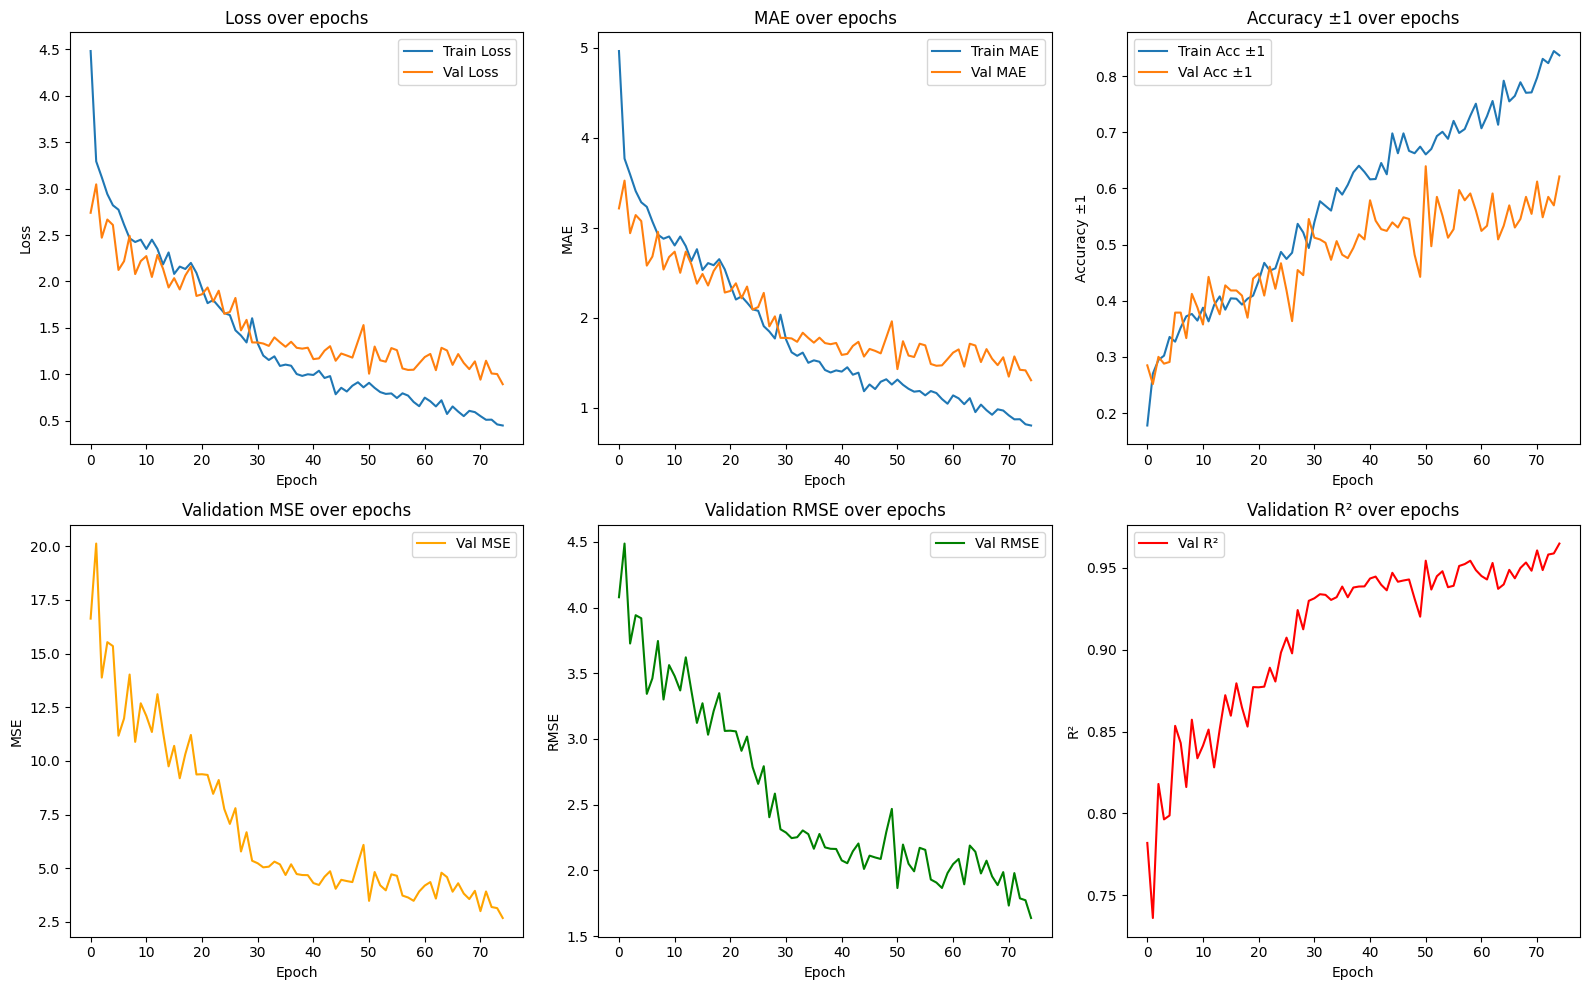

In [13]:
plot_training_history(train_history_all, val_history_all)

## Test the model

Evaluate the model in the test set

In [14]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [15]:
def test_model(model, test_loader, criterion, device):
    model.eval()

    running_loss = 0.0
    running_mae = 0.0
    running_acc = 0.0
    total_samples = 0

    all_labels = []
    all_preds = []

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)

            loss = criterion(outputs, labels)
            mae = F.l1_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels, tol=1)  # tolerance of 1

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            total_samples += batch_size

            all_labels.append(labels.cpu())
            all_preds.append(outputs.cpu())

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            avg_acc = running_acc / total_samples
            test_bar.set_postfix(loss=avg_loss, MAE=avg_mae, acc=f"{avg_acc*100:.2f}%")

    loss = running_loss / total_samples
    mae = running_mae / total_samples
    acc = running_acc / total_samples

    all_labels = torch.cat(all_labels).squeeze()
    all_preds = torch.cat(all_preds).squeeze()   

    mse = F.mse_loss(all_preds, all_labels)    
    rmse = torch.sqrt(mse).item()

    ss_res = torch.sum((all_labels - all_preds) ** 2)
    ss_tot = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2 = r2.item()


    print(f"\nTest Loss (MSE): {loss:.4f} | Test MAE: {mae:.4f} | Test Acc±1: {acc*100:.2f}% | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return loss, mae, acc, rmse, r2


In [16]:
best_model_path = 'best_model.pth' 

load_model(model, best_model_path, device)

test_loss, test_mae, test_acc, test_rmse, test_r2 = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\diogo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:1102: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
C:\Users\diogo\AppData\Local\Temp\ipykernel_3016\2857199189.py:22: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels)
Testing:  90%|█████████ | 9/10 [00:30<00:03,  3.37s/it, MAE=4.79, acc=29.50%, loss=4.33]c:\Users\diogo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:1102: UserWarning: Using a target size (torch.Size([18, 1, 1, 1])) that is different to the in


Test Loss (MSE): 4.0971 | Test MAE: 4.5508 | Test Acc±1: 33.38% | RMSE: 1.6100 | R²: 0.9623


True count: 12.00, Predicted: 16.40, Error: 4.40


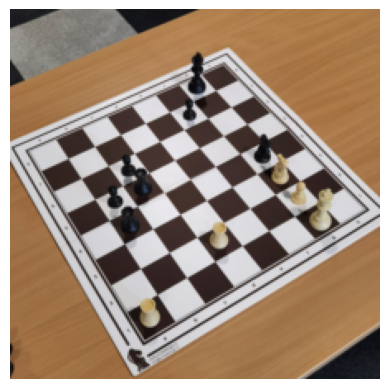

True count: 26.00, Predicted: 30.39, Error: 4.39


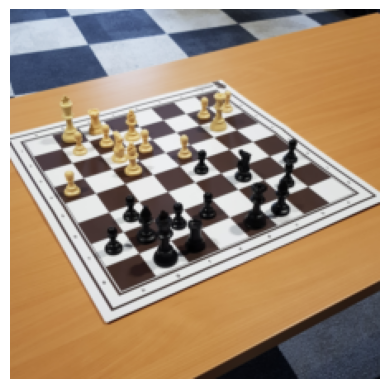

True count: 9.00, Predicted: 13.37, Error: 4.37


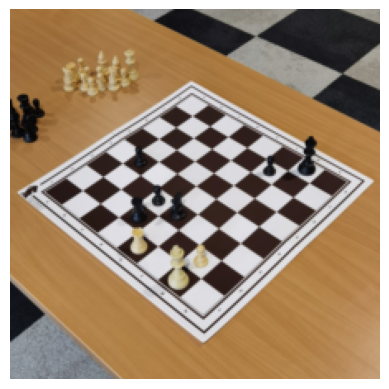

True count: 32.00, Predicted: 27.78, Error: 4.22


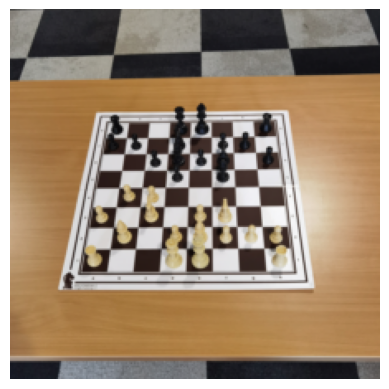

True count: 32.00, Predicted: 27.81, Error: 4.19


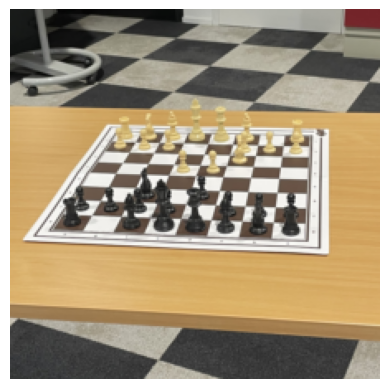

In [17]:
# Function to display an image tensor properly
def show_image(img_tensor):
    # Convert tensor from [C, H, W] to [H, W, C] and convert to numpy
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    # Clip values to valid range [0,1]
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to perform qualitative analysis on test dataset
def qualitative_analysis(model, test_dataloader, device, num_examples=5):
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # [batch_size, 1]

            outputs = model(images)

            images_list.append(images.cpu())
            labels_list.append(labels.cpu())
            preds_list.append(outputs.cpu())

    # Concatenate all batches
    all_images = torch.cat(images_list)
    all_labels = torch.cat(labels_list).squeeze()
    all_preds = torch.cat(preds_list).squeeze()

    # Calculate absolute errors
    errors = torch.abs(all_preds - all_labels)

    # Sort indices by error descending (worst predictions first)
    sorted_indices = torch.argsort(errors, descending=True)

    # Display the top `num_examples` worst predictions
    for idx in sorted_indices[:num_examples]:
        true_val = all_labels[idx].item()
        pred_val = all_preds[idx].item()
        error_val = errors[idx].item()
        print(f"True count: {true_val:.2f}, Predicted: {pred_val:.2f}, Error: {error_val:.2f}")
        show_image(all_images[idx])

qualitative_analysis(model, test_dataloader, device, num_examples=5)